In [1]:
import healpy as hp
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import time
from scipy import linalg
import scipy.sparse as sp

matplotlib.rcParams['figure.figsize'] = (7.5,7.5)
path = '/home/sambit/Downloads/PyStoch-master/src/'

tolerance = 1e-8
iterations = 100
nside = 16

In [2]:
class DirtyMap:
    def __init__(self, name):
        # Import Dirty Map of the given name from the path
        self.dirty_map = np.squeeze(np.load(path + 'NPY_files/' + name, allow_pickle = True))
        self.norm_const = 0
    
    def plot(self, *heading):
        if heading:
            hp.mollview(self.dirty_map, title = heading)
        else:
            hp.mollview(self.dirty_map)
        
    def normalise(self, H):
        self.norm_const = (np.max(H) - np.min(H))/(np.max(self.dirty_map) - np.min(self.dirty_map))
        return self.dirty_map * self.norm_const
    
    def deconvolve(self, F, l, H):    
        clean_map = sp.linalg.cgs(np.real(F.normalise(H)) + l * H, self.normalise(H),
                                  tol = tolerance, maxiter = iterations)   
        return clean_map[0]
    
    def clean_map(self, F, l, H):
        arr = self.deconvolve(F, l, H) * self.norm_const/F.norm_const
        return arr

In [3]:
class Fisher:
    def __init__(self, name):
        # Import Fisher Matrix of the given name from the path
        self.fisher = np.squeeze(np.load(path + 'NPY_files/' + name, allow_pickle = True))
        self.norm_const = 0
        
    def normalise(self, H):
        self.norm_const = (np.max(H) - np.min(H))/(np.max(self.fisher) - np.min(self.fisher))
        return self.fisher * self.norm_const

In [4]:
class Hessian:
    def __init__(self, nside):
        self.nside = nside
        self.npix = hp.nside2npix(self.nside)
        
    def gradient_hessian(self):
        nbrs = []
        for i in range(self.npix):
            nbrs.append(hp.get_all_neighbours(self.nside, hp.pix2ang(self.nside, i)[0], hp.pix2ang(self.nside, i)[1]))
       
        nbrs_len = np.array([len(nbr_row) for nbr_row in nbrs]).reshape(-1, 1)
        H = (np.eye(self.npix) * 2) * nbrs_len
        for i in range(self.npix):
            for j in nbrs[i]:
                H[i, j] -= 2
        return H
    
    def norm_hessian(self):
        return np.eye(self.npix)

In [5]:
H = Hessian(nside).gradient_hessian()
F = Fisher('Fisher_40_1800Hz.npy')

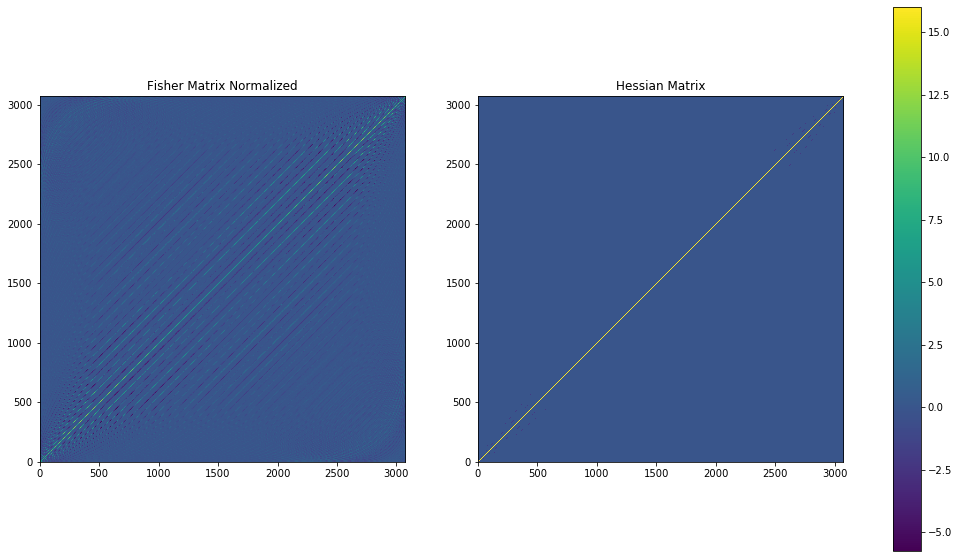

In [6]:
fisher = F.normalise(H)

fig, axs = plt.subplots(1, 2, figsize = (15*5//4, 10))
vmin = np.min([np.min(np.real(fisher)), np.min(H)])
vmax = np.max([np.max(np.real(fisher)), np.max(H)])

im = axs[0].imshow(np.real(fisher), origin = 'lower', vmin = vmin, vmax = vmax)
axs[0].set_title('Fisher Matrix Normalized')

im = axs[1].imshow(H, origin = 'lower', vmin = vmin, vmax = vmax)
axs[1].set_title('Hessian Matrix')

fig.colorbar(im, ax = axs.ravel().tolist())
plt.show()

/home/sambit/anaconda3/lib/python3.7/site-packages/healpy/projector.py:201: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


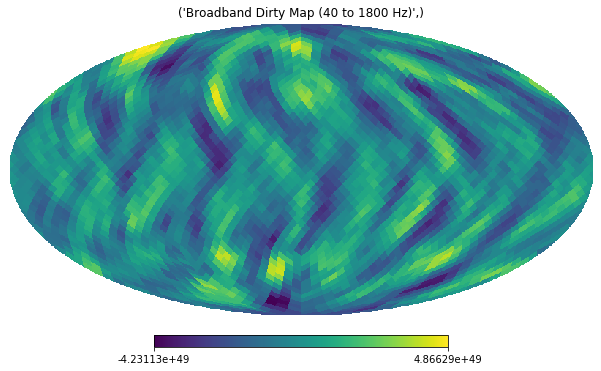

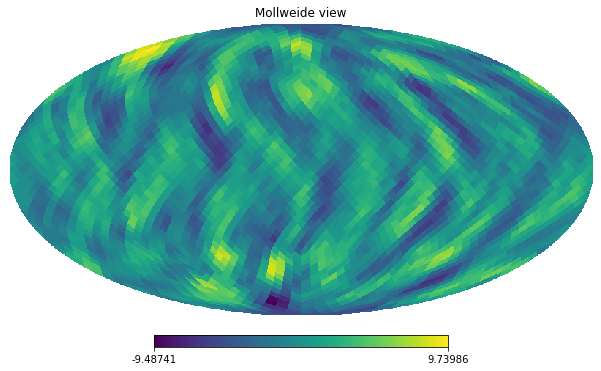

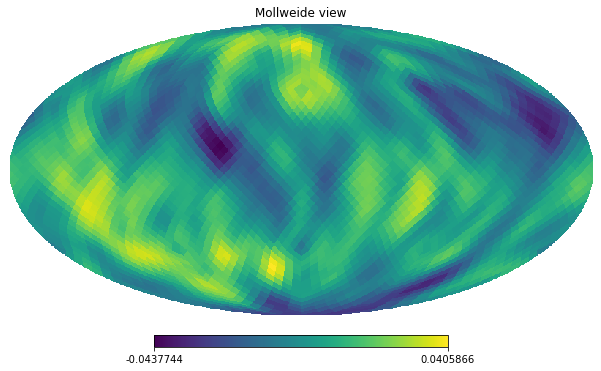

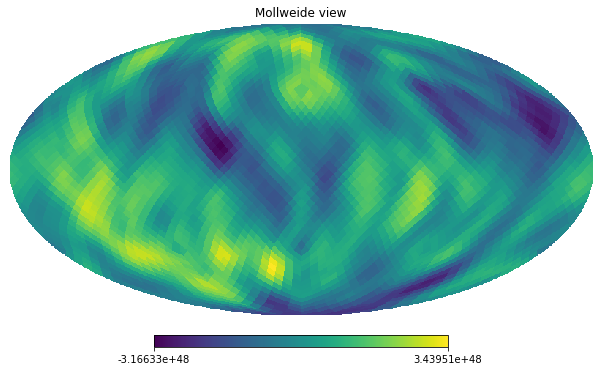

In [7]:
D = DirtyMap('Dirty_Map_40_1800Hz.npy')
D.plot('Broadband Dirty Map (40 to 1800 Hz)')
plt.savefig('DirtyMap.jpg')
d_n = D.normalise(H)
hp.mollview(d_n)
s_n = D.deconvolve(F, 50, H)
hp.mollview(s_n)
s = D.clean_map(F, 50, H)
hp.mollview(s)

### Narrow Band Analysis

Frequencies available:
* 40 Hz
* 120 Hz
* 500 Hz
* 1000 Hz

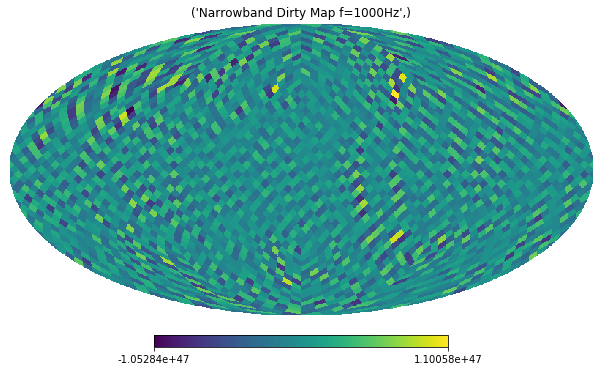

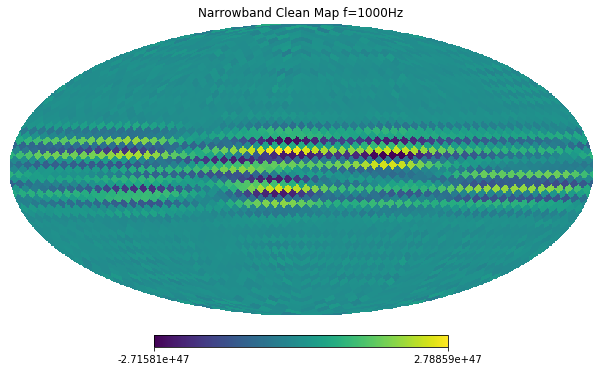

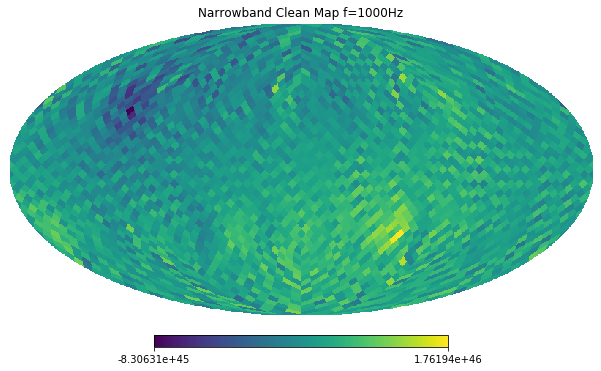

In [19]:
freq = 1000
D2 = DirtyMap('narrowBand/Dirty_Map_' + '_'.join([str(freq), str(freq) + 'Hz.npy']))
F2 = Fisher('narrowBand/Fisher_' + '_'.join([str(freq), str(freq) + 'Hz.npy']))

D2.plot('Narrowband Dirty Map f=1000Hz')
plt.savefig('DirtyMap_1000Hz')
# for l in [5,10,50,100,500]:
#     hp.mollview(D2.clean_map(F2, l, H), title='Narrowband Clean Map f=500Hz')

hp.mollview(D2.clean_map(F2, 0, H), title='Narrowband Clean Map f=1000Hz')
plt.savefig('CleaMap_1000Hz_unreg_100iters')
hp.mollview(D2.clean_map(F2, 5, H), title='Narrowband Clean Map f=1000Hz')
plt.savefig('CleanMap_1000Hz_gradreg5')